## Entrega Machine Learning 2
David Prokes

### Introducción
Los datos *datos_practica_ML2.csv* corresponden a las medidas realizadas por la estación de control de la calidad del aire del Hospital Joan March desde 2002 hasta 2018. Conteniendo las siguientes variables:

- ***DATA_HI***: Fecha de la medición.
- ***PERIODE_HI***: Hora de la medición.
- ***SO2_HI***: Concentración de dióxido de azufre (SO₂) en el aire. Medido en microgramos por metro cúbico (µg/m³).
- ***NO_HI***: Concentración de monóxido de nitrógeno (NO) en el aire.
- ***NO2_HI***: Concentración de dióxido de nitrógeno (NO₂).
- ***NOX_HI***: Concentración total de óxidos de nitrógeno (NOx = NO + NO₂).
- ***O3_HI***: Concentración de ozono (O₃).
- ***PM2,5_HI***: Concentración de partículas en suspensión de diámetro menor o igual a 2.5 micrómetros (PM2.5).
- ***PM10_HI***: Concentración de partículas en suspensión de diámetro menor o igual a 10 micrómetros (PM10).
- ***DD_HI***: Dirección del viento (Degrees Direction). Expresado en grados, donde 0° es el norte, 90° es el este, etc.
- ***VV_HI***: Velocidad del viento (Velocidad en m/s).
- ***TMP_HI***: Temperatura del aire (en grados Celsius).
- ***HR_HI***: Humedad relativa (%).
- ***PRB_HI***: Presión barométrica (hPa).
- ***LL_HI***: Nivel de radiación solar o luminosidad.
- ***RS_HI***: Radiación solar global (W/m²).

Donde, las concentraciones de los contaminantes SO2, NO, NO2, O3, PM10, PM2,5, benceno, tolueno y chileno aparecen en microgramos por metro cúbico (µg/m³); las unidades del contaminante CO son miligramos por metro cúbico (mg/m³); y para cada contaminante se incluye un “flag” o indicador de estado, donde V significa que el dato es válido.

Con todo ello el objetivo de la práctica se enfoca en definir una variable objetivo que represente la calidad del aire, para posteriormente aplicar un modelo de clasificación de aprendizaje automático supervisado. De esta manera, podremos evaluar si un modelo de clasificación es capaz de aprender los patrones que definen la calidad del aire sin conocer explícitamente los umbrales.

### Preparación de los datos
Este apartado está enfocado a cargar los datos correspondientes de la práctica, así como, aplicar una exploración y preparación de los mismos. Al explorar los datos resulta crucial entender de que se trata la variable *PERIODE_HI*. Así, a continuación, se aprecia que los valores únicos de dicha variable coinciden con las horas del día 1-24. Por lo que, podemos extraer que la muestra tiene un total de 6127 días de mediciones.

In [48]:
# Cargamos todas las librerias necesarias:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos los datos para su exploración:
df = pd.read_csv('datos_practica_ML2\datos_practica_ML2.csv')

# Eliminamos los valores NaN de la variable 'PERIODE_HI':
df.drop(df[df['PERIODE_HI'].isna()].index, inplace=True)

# Aplicamos recuento de valores únicos de la variable 'PERIODE_HI':
df['PERIODE_HI'].value_counts(dropna=False).sort_index()

PERIODE_HI
1.0     6127
2.0     6127
3.0     6127
4.0     6127
5.0     6127
6.0     6127
7.0     6127
8.0     6127
9.0     6127
10.0    6127
11.0    6127
12.0    6127
13.0    6127
14.0    6127
15.0    6127
16.0    6127
17.0    6127
18.0    6127
19.0    6127
20.0    6127
21.0    6127
22.0    6127
23.0    6127
24.0    6127
Name: count, dtype: int64

In [49]:
# Convertimos 'DATA_HI' a formato datetime:
df['DATA_HI'] = pd.to_datetime(df['DATA_HI'])

# Creamos 'FECHA' como la variable combinada de la fecha y las horas:
df['FECHA'] = df['DATA_HI'] + pd.to_timedelta(df['PERIODE_HI'], unit='h')

# Mostramos las primeras filas para verificar que se ha hecho correctamente:
print(df[['FECHA', 'DATA_HI', 'PERIODE_HI']].head(10))

C:\Users\idavi\AppData\Local\Temp\ipykernel_1964\3244086055.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATA_HI'] = pd.to_datetime(df['DATA_HI'])


                FECHA    DATA_HI  PERIODE_HI
0 2011-01-01 01:00:00 2011-01-01         1.0
1 2011-01-01 02:00:00 2011-01-01         2.0
2 2011-01-01 06:00:00 2011-01-01         6.0
3 2011-01-01 07:00:00 2011-01-01         7.0
4 2011-01-01 17:00:00 2011-01-01        17.0
5 2011-01-01 19:00:00 2011-01-01        19.0
6 2011-01-02 04:00:00 2011-01-02         4.0
7 2011-01-02 05:00:00 2011-01-02         5.0
8 2011-01-02 08:00:00 2011-01-02         8.0
9 2011-01-02 16:00:00 2011-01-02        16.0


### Definición de la variable objetivo
En el documento *INFORME_QUALITAT_AIRE_ILLES_BALEARS_2021* puede verse una clasificación de la calidad del aire individualmente para cada contaminante, donde los umbrales pueden variar en función de si la medición es horaria, diaria o anual. Analizando los datos facilitados, las mediciones proporcionadas parecen ser horarias. Lo que resultará esencial emplearlas en este formato de tiempo, para mantener un volumen considerable de observaciones.

Concretamente, en las páginas 8 y 9 se establecen los límites oficiales y recomendados por la OMS respectivamente. De las que se extraen únicamente dos variables con límites horarios. No obstante, dado el buen nivel de calidad del aire en Mallorca, aplicar dichos límites resultaría en un desbalanceo singificativo de clases. Por lo que, se ha optado por emplear los límites diarios, aplicándose así, una evaluación más restrictiva sobre la calidad del aire de Mallorca y pudiéndose incluir un mayor número de variables.

- **SO₂**: se trata de un gas contaminante que se libera principalmente por la combustión de combustibles fósiles (e.g., carbón, petróleo) en centrales eléctricas e industrias.
- **NO₂**: se trata de un gas que se forma principalmente por emisiones de vehículos y procesos de combustión industrial.
- **PM10**: se tratan de aquellas partículas en suspensión que provienen de fuentes naturales (e.g., polvo, cenizas volcánicas) o antropogénicas (e.g., emisiones de vehículos, construcción, industria).
- **PM2.5**: se tratan de aquellas partículas en suspensión que provienen de la combustión (e.g., vehículos, centrales eléctricas) y de procesos industriales.
- **O₃**: se trata de un contaminante secundario, formado por reacciones químicas entre contaminantes primarios, que afecta la calidad del aire y la salud humana.

Los correspondientes límites son:

- **SO₂**: 350 µg/m³ y 40 µg/m³ (límite horario para la protección de la salud humana y diario recomendado por la OMS)
- **NO₂**: 200 µg/m³ y 25 µg/m³ (límite horario para la protección de la salud humana y diario recomendado por la OMS)
- **PM10**: 45 µg/m³ (límite diario recomendado por la OMS)
- **PM2.5**: 15 µg/m³ (límite diario recomendado por la OMS)
- **O₃**: 120 µg/m³ y 100 µg/m³ (límite octohorario para la protección de la salud humana y recomendado por la OMS respectivamente)

Así, estas serán las variables a considerar como características y, mediante las cuáles, se establecerán los umbrales para clasificar la calidad del aire, resultante del valor promedio obtenido entre las dos variables, de cuyos umbrales se extraerán valores de 0 a 3 (Mala calidad, Regular, Buena y Excelente). El cálculo de los umbrales se realiza respetando el mismo procedimiento aplicado en el informe, aunque escogiendo los valores límites más restrictivos.

In [50]:
# Filtramos por las variables seleccionadas para determinar la calidad del aire:
df = df[['FECHA', 
         'SO2_HI', 'FL_SO2', 
         'NO2_HI', 'FL_NO2', 
         'PM10_HI', 'FL_PM10',
         'PM2,5_HI', 'FL_PM2,5',
         'O3_HI', 'FL_O3']]

# Descartamos las mediciones no válidas:
df = df[
    (df['FL_SO2'] == 'V') & 
    (df['FL_NO2'] == 'V') & 
    (df['FL_PM10'] == 'V') & 
    (df['FL_PM2,5'] == 'V') & 
    (df['FL_O3'] == 'V')
]

# Eliminamos las columnas de flags:
df.drop(columns=['FL_SO2', 'FL_NO2', 'FL_PM10', 'FL_PM2,5', 'FL_O3'], inplace=True)

# Mostramos estadísticas de las variables:
df.describe()

,FECHA,SO2_HI,NO2_HI,PM10_HI,"PM2,5_HI",O3_HI
count,50954,50954.000000,50954.000000,50954.000000,50954.000000,50954.000000
mean,2014-04-30 05:54:37.827059712,1.984811,5.851763,16.256442,7.563722,77.256022
min,2010-07-16 01:00:00,0.000000,0.000000,1.000000,0.820000,3.000000
25%,2012-04-04 05:15:00,1.000000,3.000000,10.000000,4.000000,63.700000
50%,2014-01-11 17:30:00,1.525000,3.000000,14.250000,6.765000,76.000000
75%,2016-07-28 22:45:00,2.200000,7.150000,20.000000,10.000000,90.000000
max,2019-11-29 00:00:00,39.000000,67.000000,240.000000,91.225000,168.425000
std,NaN,1.560197,5.151121,10.138179,5.008972,20.777156


En la tabla anterior se aprecia que el valor máximo del contaminante *SO₂* se encuentra muy por debajo del límite horario (350 µg/m³) e incluso diario (40 µg/m³). Mientras que, una pequeña proporción de los datos, menos del 25%, se encuentra cercano al límite diario de las siguientes variables: *NO₂* (25 µg/m³), *PM10* (45 µg/m³), *PM2.5* (15 µg/m³) y *O₃* (100 µg/m³).

In [51]:
# Creamos una función para determinar los umbrales de calidad del aire de los contaminantes:
def umbrales_contaminantes(valor, VRL):
    if valor <= (1/3) * VRL:
        return 3 # Nivel excelente
    elif valor <= (2/3) * VRL:
        return 2 # Nivel bueno
    elif valor <= VRL:
        return 1 # Nivel regular
    else:
        return 0 # Nivel malo

# Aplicamos la función sobre los datos con el correspondiente límite de cada contaminante:
df['Calidad_SO2'] = df['SO2_HI'].apply(lambda x: umbrales_contaminantes(x, 40))
df['Calidad_NO2'] = df['NO2_HI'].apply(lambda x: umbrales_contaminantes(x, 25))
df['Calidad_PM10'] = df['PM10_HI'].apply(lambda x: umbrales_contaminantes(x, 45))
df['Calidad_PM2,5'] = df['PM2,5_HI'].apply(lambda x: umbrales_contaminantes(x, 15))
df['Calidad_O3'] = df['O3_HI'].apply(lambda x: umbrales_contaminantes(x, 100))

# Mostramos las primeras filas para verificar que se ha hecho correctamente:
print(df[['Calidad_SO2', 'Calidad_NO2', 'Calidad_PM10', 'Calidad_PM2,5', 'Calidad_O3']].head(10))

# Definimos la variable objetivo como el promedio de la calidad del aire de los contaminantes:
df['Objetivo'] = df[['Calidad_SO2', 'Calidad_NO2', 'Calidad_PM10', 'Calidad_PM2,5', 'Calidad_O3']].mean(axis=1).round().astype(int)

# Eliminamos las columnas de calidad de los contaminantes:
df.drop(columns=['Calidad_SO2', 'Calidad_NO2', 'Calidad_PM10', 'Calidad_PM2,5', 'Calidad_O3'], inplace=True)

# Observamos los valores únicos clasificados en base al promedio de los umbrales:
df['Objetivo'].value_counts().sort_index(ascending=False)

    Calidad_SO2  Calidad_NO2  Calidad_PM10  Calidad_PM2,5  Calidad_O3
0             3            3             2              0           2
1             3            3             2              0           2
2             3            3             3              2           2
3             3            3             2              1           2
4             3            3             2              1           2
5             3            3             2              1           2
7             3            3             3              2           2
9             3            3             3              2           2
10            3            3             3              2           2
11            3            3             2              1           2


Objetivo
3    17102
2    32423
1     1429
Name: count, dtype: int64

De los anteriores resultados, podemos ver que de aplicar la estrategia del promedio entre los niveles de calidad extraídos para cada contaminante, no se asigna el nivel 0 (Malo) para ninguno de los datos. Por lo que, la ausencia del nivel 0 implica que el modelo de clasificación se enfocará únicamente en predecir tres categorías: (Excelente, Bueno y Regular). No se aplica una estrategia de niveles mínimos de calidad, ya que, dado que se han aplicado umbrales diarios sobre datos horarios, se estaría añadiendo un nivel más de sobreestimación de la mala calidad del aire en Mallorca. 

### Modelos de clasificación
En este apartado se comparará el rendimiento entre diferentes modelos de clasificación. Entrando más en detalle, tenemos un problema de clasificación multiclase (3 clases) con 5 características. Por tanto, entre otras opciones, podrían implementarse los siguintes modelos:

- Support Vector Machines (SVM) con núcleo lineal
- Support Vector Machines (SVM) con núcleo radial
- Regresión Logística Multinomial
- Random Forest Classification

In [52]:
# Primero de todo importamos las funciones necesarias de sklearn:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Dividimos los datos entre las características y la variable objetivo:
df_y = df['Objetivo'].copy()
df_x = df.drop(columns=['Objetivo', 'FECHA'],axis=1).copy()

# Creamos un conjunto de datos de entrenamiento y otro de prueba:
x_train, x_test,  y_train, y_test = train_test_split(df_x,df_y, test_size=0.2, random_state = 11631)

# Normalizamos los datos, ya que aglunos modelos son sensibles a la escala de las características:
scaler = StandardScaler()
x_train_1 = scaler.fit_transform(x_train)
x_test_1 = scaler.transform(x_test)

**Modelo SVM con núcleo lineal y Validación Cruzada 5-veces**

In [53]:
# Modelo SVM con núcleo lineal y Validación Cruzada 5-veces.

# Definimos el espacio de búsqueda de hiperparámetros:
M1_grid = {'C': [0.01, 0.1, 1, 5, 10]}

# Creamos un modelo SVM con kernel lineal y Validación Cruzada 5-veces:
M1_VC = GridSearchCV(SVC(kernel='linear', random_state=11631), 
                         M1_grid,  # Diccionario con los hiperparámetros
                         cv=5,  # Validación cruzada con 5 particiones
                         scoring='accuracy',  # Métrica de evaluación
                         verbose=1)  # Muestra el progreso

# Entrenamos el modelo con los datos de entrenamiento:
M1_VC.fit(x_train_1[:2500,], y_train.iloc[:2500])

# Buscamos el valor óptimo del coste en función de la precisión:
M1_VC_cost = M1_VC.best_params_['C']

# Creamos un modelo SVM con kernel lineal y el coste óptimo:
M1 = SVC(kernel='linear', 
         C=M1_VC_cost, 
         random_state=11631)

# Entrenamos el modelo con los datos de entrenamiento:
M1.fit(x_train_1, y_train)

# Generamos predicciones sobre el conjunto de prueba:
M1_pred = M1.predict(x_test_1)

# Calculamos varias métricas de evaluación:
print(classification_report(y_test, M1_pred, target_names=['Regular', 'Bueno', 'Excelente']))

# Obtenemos la matriz de confusión:
M1_conf = confusion_matrix(y_test, M1_pred)

# Convertimos la matriz en un DataFrame con etiquetas:
M1_conf = pd.DataFrame(M1_conf, 
                       index=['Regular', 'Bueno', 'Excelente'], 
                       columns=['Regular', 'Bueno', 'Excelente'])

print("\nMatriz de Confusión:")
print(M1_conf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
              precision    recall  f1-score   support

     Regular       0.84      0.59      0.70       310
       Bueno       0.92      0.93      0.92      6444
   Excelente       0.87      0.88      0.87      3437

    accuracy                           0.90     10191
   macro avg       0.88      0.80      0.83     10191
weighted avg       0.90      0.90      0.90     10191


Matriz de Confusión:
           Regular  Bueno  Excelente
Regular        184    126          0
Bueno           35   5964        445
Excelente        0    421       3016


**Modelo SVM con núcleo radial y Validación Cruzada 5-veces**

In [54]:
# Modelo SVM con núcleo radial y Validación Cruzada 5-veces.

# Definimos el espacio de búsqueda de hiperparámetros:
M2_grid = {'C': [0.01, 0.1, 1, 5, 10],
        'gamma': [0.01, 0.1, 1, 5, 10]}

# Creamos un modelo SVM con kernel rbf y Validación Cruzada 5-veces:
M2_VC = GridSearchCV(SVC(kernel='rbf', random_state=11631), 
                         M2_grid,  # Diccionario con los hiperparámetros
                         cv=5,  # Validación cruzada con 5 particiones
                         scoring='accuracy',  # Métrica de evaluación
                         verbose=1)  # Muestra el progreso

# Entrenamos el modelo con los datos de entrenamiento:
M2_VC.fit(x_train_1[:2500], y_train.iloc[:2500])

# Buscamos el valor óptimo del coste y gamma en función de la precisión:
M2_VC_cost = M2_VC.best_params_['C']
M2_VC_gamma = M2_VC.best_params_['gamma']

# Creamos un modelo SVM con kernel rbf y los parámetros óptimos:
M2 = SVC(kernel='rbf', 
         C=M2_VC_cost, 
         gamma=M2_VC_gamma,
         random_state=11631)

# Entrenamos el modelo con los datos de entrenamiento:
M2.fit(x_train_1, y_train)

# Generamos predicciones sobre el conjunto de prueba:
M2_pred = M2.predict(x_test_1)

# Calculamos varias métricas de evaluación:
print(classification_report(y_test, M2_pred, target_names=['Regular', 'Bueno', 'Excelente']))

# Obtenemos la matriz de confusión:
M2_conf = confusion_matrix(y_test, M2_pred)

# Convertimos la matriz en un DataFrame con etiquetas:
M2_conf = pd.DataFrame(M2_conf, 
                       index=['Regular', 'Bueno', 'Excelente'], 
                       columns=['Regular', 'Bueno', 'Excelente'])

print("\nMatriz de Confusión:")
print(M2_conf)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
              precision    recall  f1-score   support

     Regular       0.91      0.80      0.85       310
       Bueno       0.98      0.98      0.98      6444
   Excelente       0.98      0.97      0.98      3437

    accuracy                           0.97     10191
   macro avg       0.95      0.92      0.94     10191
weighted avg       0.97      0.97      0.97     10191


Matriz de Confusión:
           Regular  Bueno  Excelente
Regular        248     62          0
Bueno           24   6339         81
Excelente        0     90       3347


**Modelo de Regresión Logística Multinomial y Validación Cruzada 5-veces**

In [55]:
# Modelo de Regresión Logística Multinomial y Validación Cruzada 5-veces.

# Definimos el espacio de búsqueda de hiperparámetros:
M3_grid = {'C': [0.01, 0.1, 1, 10]}

# Creamos un modelo de Regresión Logística y Validación Cruzada 5-veces:
M3_VC = GridSearchCV(LogisticRegression(solver='lbfgs', 
                                        max_iter=500,
                                        random_state=11631
                                        ),
                     M3_grid, # Diccionario con los hiperparámetros  
                     cv=5,    # Validación cruzada con 5 particiones
                     scoring='accuracy',  # Métrica de evaluación
                     verbose=1    # Muestra el progreso
                     )

# Entrenamos el modelo con los datos de entrenamiento:
M3_VC.fit(x_train_1, y_train)

# Buscamos el valor óptimo del coste en función de la precisión:
M3_VC_cost = M3_VC.best_params_['C']

# Creamos un modelo de Regresión Logística Multinomial:
M3 = LogisticRegression(solver='lbfgs',             # Algoritmo de optimización eficiente
                        max_iter=500,               # Iteraciones máximas para la convergencia
                        C=M3_VC_cost,               # Coste óptimo
                        random_state=11631
)

# Entrenamos el modelo con los datos de entrenamiento:
M3.fit(x_train_1, y_train)

# Generamos predicciones sobre el conjunto de prueba
M3_pred = M3.predict(x_test_1)

# Calculamos varias métricas de evaluación:
print(classification_report(y_test, M3_pred, target_names=['Regular', 'Bueno', 'Excelente']))

# Obtenemos la matriz de confusión:
M3_conf = confusion_matrix(y_test, M3_pred)

# Convertimos la matriz en un DataFrame con etiquetas:
M3_conf = pd.DataFrame(M3_conf, 
                       index=['Regular', 'Bueno', 'Excelente'], 
                       columns=['Regular', 'Bueno', 'Excelente'])

print("\nMatriz de Confusión:")
print(M3_conf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
              precision    recall  f1-score   support

     Regular       0.84      0.56      0.67       310
       Bueno       0.91      0.93      0.92      6444
   Excelente       0.87      0.88      0.87      3437

    accuracy                           0.90     10191
   macro avg       0.88      0.79      0.82     10191
weighted avg       0.90      0.90      0.90     10191


Matriz de Confusión:
           Regular  Bueno  Excelente
Regular        174    136          0
Bueno           33   5964        447
Excelente        0    421       3016


**Random Forest Classification y Validación Cruzada 5-veces**

In [56]:
# Modelo Random Forest y Validación Cruzada 5-veces.

# Definimos el espacio de búsqueda de hiperparámetros
M4_grid = {
    'n_estimators': [50, 100, 200],       # Número de árboles
    'max_depth': [None, 10, 20],         # Profundidad máxima
    'min_samples_split': [2, 5, 10],     # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]        # Mínimo número de muestras en una hoja
}

# Creamos un modelo Random Forest y GridSearch con Validación Cruzada:
M4_VC = GridSearchCV(
    RandomForestClassifier(random_state=11631),
    M4_grid,       # Diccionario con los hiperparámetros
    cv=5,          # Validación cruzada con 5 particiones
    scoring='accuracy',  # Métrica de evaluación
    verbose=1,      # Muestra el progreso
    n_jobs=-1       # Usa todos los núcleos disponibles para entrenar
)

# Entrenamos el modelo con los datos de entrenamiento:
M4_VC.fit(x_train.iloc[:5000], y_train.iloc[:5000])

# Buscamos los mejores hiperparámetros
M4_VC_parametros = M4_VC.best_params_

# Creamos el modelo con los hiperparámetros óptimos:
M4 = RandomForestClassifier(
    n_estimators=M4_VC_parametros['n_estimators'],
    max_depth=M4_VC_parametros['max_depth'],
    min_samples_split=M4_VC_parametros['min_samples_split'],
    min_samples_leaf=M4_VC_parametros['min_samples_leaf'],
    random_state=11631
)

# Entrenamos el modelo con los datos de entrenamiento
M4.fit(x_train, y_train)

# Generamos predicciones sobre el conjunto de prueba
M4_pred = M4.predict(x_test)

# Calculamos varias métricas de evaluación
print(classification_report(y_test, M4_pred, target_names=['Regular', 'Bueno', 'Excelente']))

# Obtenemos la matriz de confusión
M4_conf = confusion_matrix(y_test, M4_pred)

# Convertimos la matriz en un DataFrame con etiquetas
M4_conf = pd.DataFrame(M4_conf, 
                       index=['Regular', 'Bueno', 'Excelente'], 
                       columns=['Regular', 'Bueno', 'Excelente'])

# Mostramos la matriz de confusión
print("\nMatriz de Confusión:")
print(M4_conf)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
              precision    recall  f1-score   support

     Regular       0.99      0.96      0.98       310
       Bueno       1.00      1.00      1.00      6444
   Excelente       1.00      1.00      1.00      3437

    accuracy                           1.00     10191
   macro avg       1.00      0.99      0.99     10191
weighted avg       1.00      1.00      1.00     10191


Matriz de Confusión:
           Regular  Bueno  Excelente
Regular        298     12          0
Bueno            2   6440          2
Excelente        0      8       3429


### Elección del modelo
A continuación, en base a la visualización de los resultados obtenidos de los cuatro modelos estimados anteriormente, se selecciona el mejor modelo. 

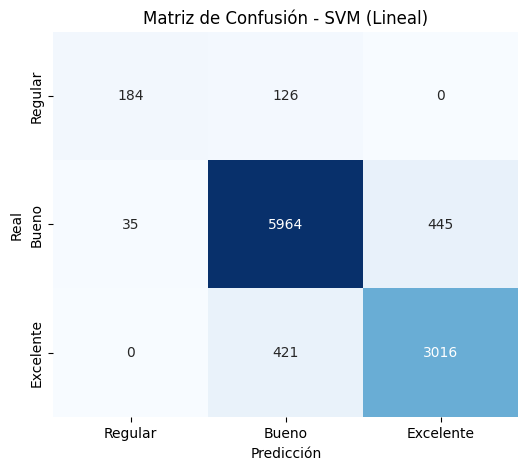

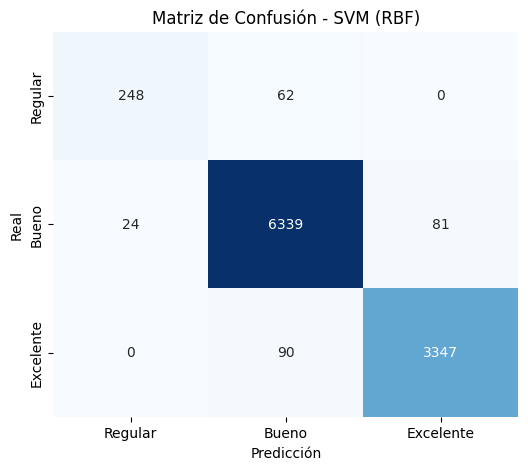

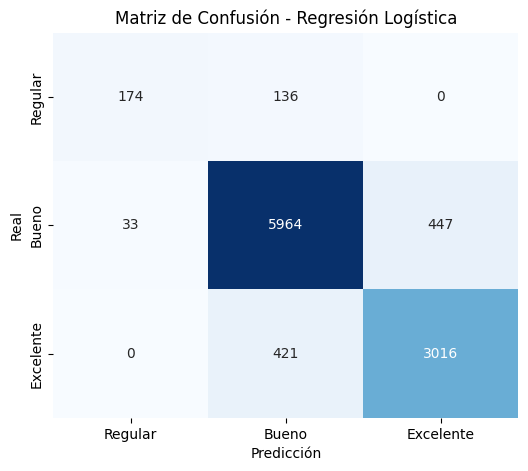

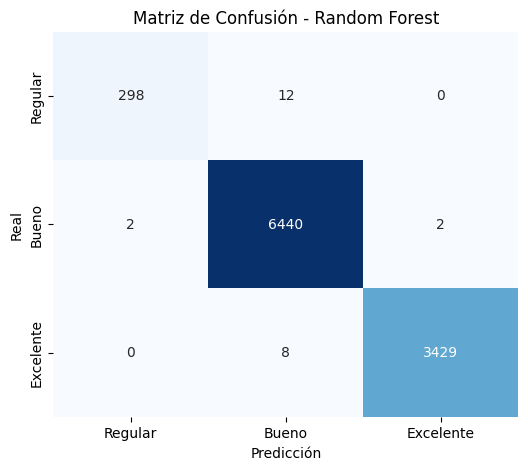

In [57]:
# Función para graficar una matriz de confusión
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Visualizar las matrices de confusión de los modelos
plot_confusion_matrix(M1_conf, "Matriz de Confusión - SVM (Lineal)")
plot_confusion_matrix(M2_conf, "Matriz de Confusión - SVM (RBF)")
plot_confusion_matrix(M3_conf, "Matriz de Confusión - Regresión Logística")
plot_confusion_matrix(M4_conf, "Matriz de Confusión - Random Forest")

En las gráficas de las matrices de confusión se observa que el SVM con núcleo lineal obtiene un desempeño aceptable, aunque limitado por el desbalance de datos, especialmente en la clasificación de la calidad del aire "Regular". Esto es común en modelos lineales, como también se aprecia en la regresión logística, que enfrenta dificultades similares y logra resultados ligeramente inferiores. Ambos modelos se ven afectados por la falta de capacidad para modelar relaciones no lineales entre las características. Por otro lado, el SVM con núcleo radial mejora notablemente los resultados al introducir no linealidad, lo que le permite capturar patrones más complejos y clasificar de manera más precisa las diferentes categorías. Sin embargo, el modelo de Random Forest destaca como el mejor, ya que maneja de forma eficaz el desbalance de clases y las relaciones no lineales, logrando una clasificación precisa incluso en la clase minoritaria "Regular". Esto refleja la capacidad del Random Forest para adaptarse a la complejidad de los datos, siendo la opción más adecuada para este problema.

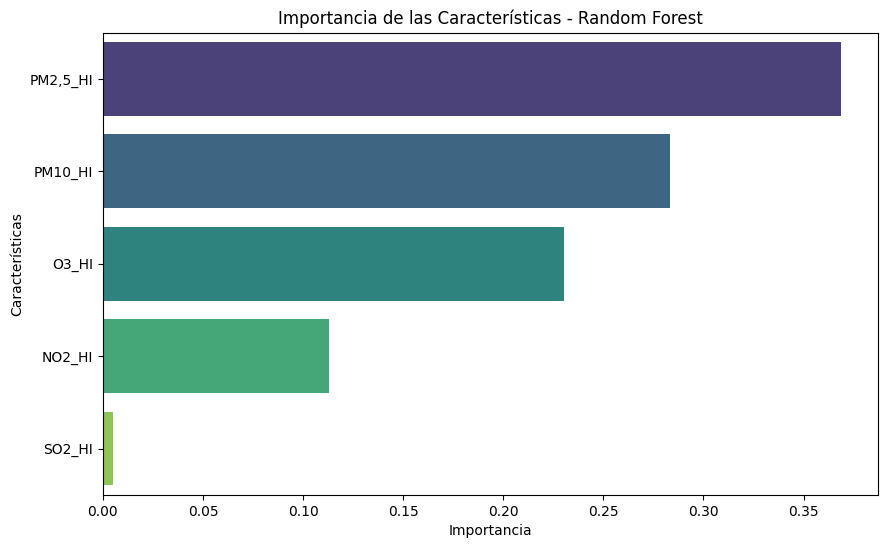

In [58]:
# Crear DataFrame con las importancias de las características
feature_importances = pd.DataFrame({
    'Feature': df_x.columns,
    'Importance': M4.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis', hue='Feature', dodge=False)
plt.title("Importancia de las Características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.legend([], [], frameon=False)  # Elimina la leyenda si no es necesaria
plt.show()


En la gráfica anterior puede visualizarse cuanto de decisivas son cada una de las características para clasificar la calidad del aire en Mallorca. Así, el modelo Random Forest identifica que las partículas en suspensión (*PM2.5* y *PM10*) son las variables más influyentes en la calidad del aire, seguidas por el ozono troposférico. Esto es algo que podríamos haber intuido en la primera exploración de los datos, donde los datos reflejaban valores más elevados para los contaminantes *PM2.5* y *PM10*.

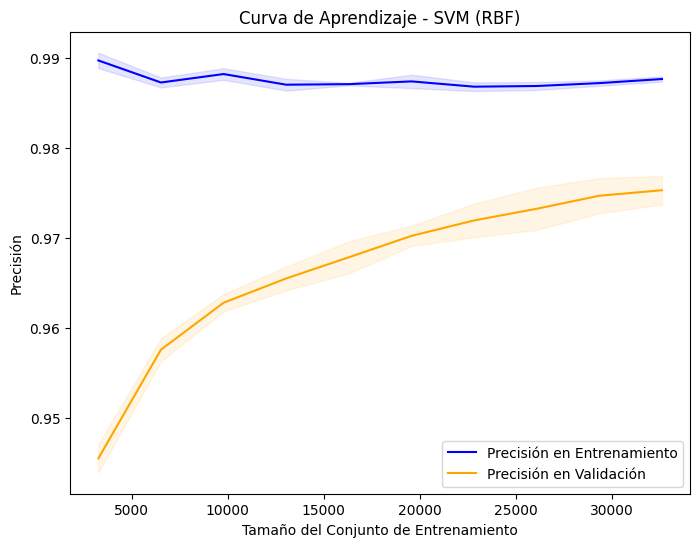

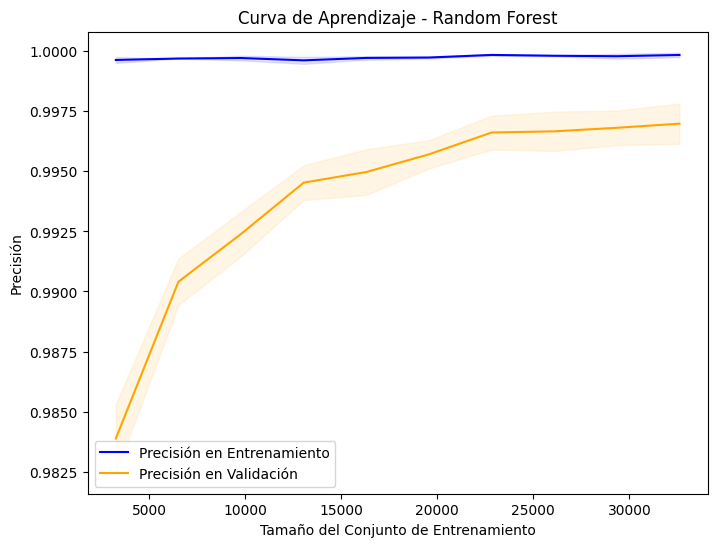

In [59]:
from sklearn.model_selection import learning_curve

# Función para graficar curva de aprendizaje
def plot_learning_curve(estimator, title, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Precisión en Entrenamiento", color="blue")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
    plt.plot(train_sizes, test_mean, label="Precisión en Validación", color="orange")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="orange")
    plt.title(title)
    plt.xlabel("Tamaño del Conjunto de Entrenamiento")
    plt.ylabel("Precisión")
    plt.legend(loc="best")
    plt.show()

# Graficar curvas de aprendizaje para cada modelo
plot_learning_curve(M2, "Curva de Aprendizaje - SVM (RBF)", x_train_1, y_train)
plot_learning_curve(M4, "Curva de Aprendizaje - Random Forest", x_train, y_train)


Las gráficas anteriores representan las curvas de aprendizaje para los modelos SVM con núcleo radial (RBF) y Random Forest. En ambas, se evalúa la precisión en función del tamaño del conjunto de entrenamiento, proporcionando información sobre el comportamiento de los modelos a medida que se incrementan los datos disponibles. De esta manera, aunque ambos modelos muestran buen desempeño, Random Forest presenta una curva de aprendizaje más favorable debido a su capacidad de generalización, evidenciada por la convergencia entre las líneas de precisión en el conjunto de entrenamiento y de prueba.

### Conclusiones
El Random Forest obtiene resultados consistentes en ser el mejor modelo de clasificación para el caso analizado, obteniendo una precisión prácticamente del 100%. Pudiendo ser un buen sustituto al empleo de los intérvalos directamente, dada la automatización del proceso y el excelente trade-off entre coste computacional y capacidad predictiva.

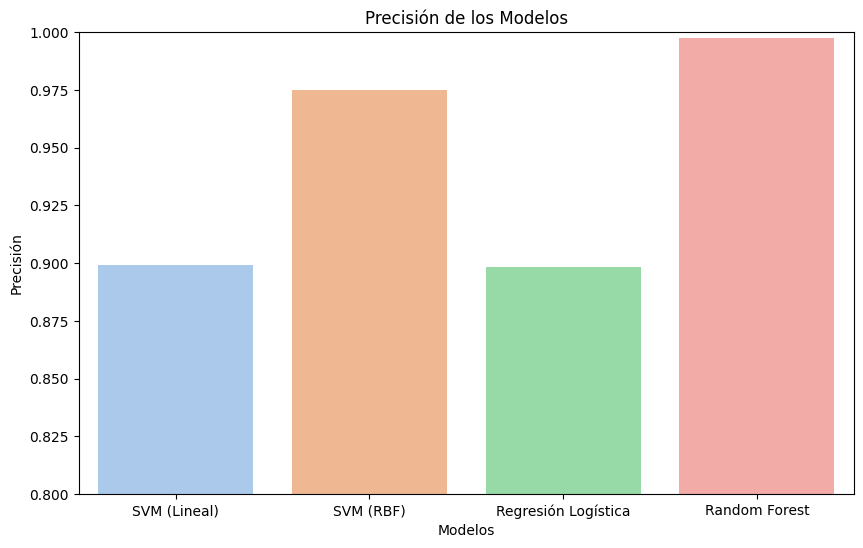

In [60]:
# Visualizar métricas comparativas
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Precisión', data=metrics_df, palette='pastel', hue='Modelo', dodge=False)
plt.title("Precisión de los Modelos")
plt.ylabel("Precisión")
plt.xlabel("Modelos")
plt.ylim(0.8, 1.0)  # Establecer límites en el eje y para más claridad
plt.legend([], [], frameon=False)  # Eliminar leyenda
plt.show()